In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Machine Learning in Spark
#### Objective: Build a classification algorithm using Spark ML
#### As part of this activity,
#### 1. Read data, understand data using exploratory data analysis.
#### 2. Do necessary pre-processing and build machine learning classification algorithm using the libraries available in SparkML. 

### Data Representation
- **Pandas** - DataFrames represented on a single machine as Python data structures
- **RDDs** - Spark’s foundational structure Resilient Distributed Dataset is represented as a reference to partitioned data without types
- **DataFrames** - Spark’s strongly typed optimized distributed collection of rows

**All ML Algorithms need to represent data as vectors (array of Double values) in order to train machine learning algorithms**

## ML Pipelines
ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines and this concept is mostly inspired by the scikit-learn project.



### Single vs Distributed Machine Learning

#### Single Machine Learning
- In a single machine algorithm such as scikit-learn, the data isloaded into the memory of a single machine (usually as Pandas or
NumPy vectors)
- The single machine algorithm iterates (loops) over the data in memory and using a single thread (sometimes multicore) takes a
"guess" at the equation
- The error is calculated and if the error from the previous iteration is less than the tolerance or the iterations are >= max iterations then STOP<br>

#### Distributed Machine Learning
- In Distributed Machine Learning like Spark MLlib, the data is represented as an RDD or a DataFrame typically in distributed file storage such as S3, Blob Store or HDFS
- As a best practice, you should cache the data in memory across the nodes so that multiple iterations don’t have to query the disk each time
- The calculation of the gradients is distributed across all the nodes using Spark's distributed compute engine (similar to MapReduce)
- After each iteration, the results return to the driver and iterations continue until eithermax_iter or tol is reached


## Setup

#### Configure Spark Environment
Configure environment variables, Make sure you provide the correct Spark installation path/location.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install -q plotly==4.4.1

     |████████████████████████████████| 7.3MB 4.7MB/s 


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

### Starting the Spark Session
#### Create and Initialize Spark Driver
Creating a spark app that will run locally and will use as many threads as there are cores using local[*] :

In [0]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession \
      .builder \
      .appName('PySpark on Google Colab') \
      .master('local[*]') \
      .getOrCreate()

#### Verify Spark Driver -  Spark Session

In [5]:
## Verify Spark Session
spark

#### Load Dependent Libraries

#### Spark libraries

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [0]:
import numpy as np
import pandas as pd
import warnings

#### Problem Statement
The dataset is from a bank, data related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, to access if the product (bank term deposit) would be (or not) subscribed. The data and attribute description are in the folder.

#### Dataset Description
The dataset has the following attributes:
<br>1 - age (numeric)
<br>2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
<br>3 - marital_status : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
<br>4 - education (categorical: "unknown","secondary","primary","tertiary")
<br>5 - default: has credit in default? (binary: "yes","no")
<br>6 - balance: average yearly balance, in euros (numeric)
<br>7 - housing: has housing loan? (binary: "yes","no")
<br>8 - loan: has personal loan? (binary: "yes","no")
<br>9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
<br>10 - day: last contact day of the month (numeric)
<br>11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
<br>12 - duration: last contact duration, in seconds (numeric)
<br>13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
<br>14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
<br>15 - previous: number of contacts performed before this campaign and for this client (numeric)
<br>16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
<br>**17 - opened_new_td_act_no_yes - has the client subscribed to a term deposit? (binary: "yes","no")**

<html>
<font color="blue">
<br>
The idea is we have set of information about a person whether its their age the job they have the marital status whether they have loan with the bank or not etc. we're trying to decide here is whether this person open a new deposit account with this bank.
</br><br><br>
So the theory here is that if I can better target the right customers with the right offer at right time they'll convert over to actually open a deposit account with the bank so that I don't have to reach out whole population and waste a lot of money with ads or mailer or what ever have you but target only the perspective customers.
</br></font>
</html>

#### Define the schema for the dataset and use this to create the DataFrame

In [0]:
## Define Schema
bankDataSchema = StructType([
         StructField("age", IntegerType(), True),
         StructField("job", StringType(), True),
         StructField("marital_status", StringType(), True),
         StructField("education", StringType(), True),
         StructField("default", StringType(), True),
         StructField("balance", DoubleType(), True),
         StructField("housing", StringType(), True),
         StructField("loan", StringType(), True),        
         StructField("contact", StringType(), True),
         StructField("day", IntegerType(), True),
         StructField("month", StringType(), True),
         StructField("duration", DoubleType(), True),
         StructField("campaign", DoubleType(), True),
         StructField("pdays", DoubleType(), True),
         StructField("previous", DoubleType(), True),
         StructField("poutcome", StringType(), True),
         StructField("opened_new_td_act_no_yes", StringType(), True)])

#### Using the above schema read data and create DataFrame

In [0]:
# Reading and create from local files
bankDF = spark.read.format("csv")\
        .option("header", False)\
        .option("inferSchema", False)\
        .load("drive/My Drive/20191221_CSE7312c_Batch75_SparkML/SparkML/data/bank.csv", 
              schema = bankDataSchema)

# Reading and create from HDFS
# bankDF = spark.read.format("csv")\
#         .option("header", "false")\
#         .option("inferSchema", "true")\
#         .load("/user/user6/<path>/bank_data.csv", schema = bankDataSchema)
        
# bankDF = spark.read.format("csv")\
#         .option("header", "false")\
#         .option("inferSchema", "true")\
#         .load("hdfs:///user/user6/<path>/bank_data.csv", schema = bankDataSchema)

#### Verify Schema

In [10]:
bankDF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- opened_new_td_act_no_yes: string (nullable = true)



#### Check datatype of each column/field/attribute/feature

In [11]:
bankDF.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital_status', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'double'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'double'),
 ('campaign', 'double'),
 ('pdays', 'double'),
 ('previous', 'double'),
 ('poutcome', 'string'),
 ('opened_new_td_act_no_yes', 'string')]

#### Verify first few records

In [12]:
## To Show first n observations
## Use head operation to see first n observations (say, 10 observations). 
## Head operation in PySpark is similar to head operation in Pandas.
bankDF.head(10)

[Row(age=30, job=u'unemployed', marital_status=u'married', education=u'primary', default=u'no', balance=1787.0, housing=u'no', loan=u'no', contact=u'cellular', day=19, month=u'oct', duration=79.0, campaign=1.0, pdays=-1.0, previous=0.0, poutcome=u'unknown', opened_new_td_act_no_yes=u'no'),
 Row(age=33, job=u'services', marital_status=u'married', education=u'secondary', default=u'no', balance=4789.0, housing=u'yes', loan=u'yes', contact=u'cellular', day=11, month=u'may', duration=220.0, campaign=1.0, pdays=339.0, previous=4.0, poutcome=u'failure', opened_new_td_act_no_yes=u'no'),
 Row(age=35, job=u'management', marital_status=u'single', education=u'tertiary', default=u'no', balance=1350.0, housing=u'yes', loan=u'no', contact=u'cellular', day=16, month=u'apr', duration=185.0, campaign=1.0, pdays=330.0, previous=1.0, poutcome=u'failure', opened_new_td_act_no_yes=u'no'),
 Row(age=30, job=u'management', marital_status=u'married', education=u'tertiary', default=u'no', balance=1476.0, housing

In [13]:
## Above results are comprised of row like format. 
## To see the result in more interactive manner (rows under the columns), Use the show operation. 
## Show operation on train and take first 5 rows of it. 
bankDF.show(5)

+---+-----------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|        job|marital_status|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+-----------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 30| unemployed|       married|  primary|     no| 1787.0|     no|  no|cellular| 19|  oct|    79.0|     1.0| -1.0|     0.0| unknown|                      no|
| 33|   services|       married|secondary|     no| 4789.0|    yes| yes|cellular| 11|  may|   220.0|     1.0|339.0|     4.0| failure|                      no|
| 35| management|        single| tertiary|     no| 1350.0|    yes|  no|cellular| 16|  apr|   185.0|     1.0|330.0|     1.0| failure|                      no|
| 30| management|       married| tertiary|     no| 1

#### Verify the total rows and columns

In [14]:
## To Count the number of rows in DataFrame
print('Total records count is {}'.format(bankDF.count()))
## Columns count and column names
print("Total Columns count is {}".format(len(bankDF.columns)))
print("\n\nColumns are: {}".format(bankDF.columns))

Total records count is 4521
Total Columns count is 17


Columns are: ['age', 'job', 'marital_status', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'opened_new_td_act_no_yes']


#### Verify the Summary Statistics

In [15]:
## To get the summary statistics (mean, standard deviance, min ,max , count) 
#of columns in a DataFrame
bankDF.describe().show()

+-------+------------------+-------+--------------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+------------------------+
|summary|               age|    job|marital_status|education|default|           balance|housing|loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|opened_new_td_act_no_yes|
+-------+------------------+-------+--------------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+------------------------+
|  count|              4521|   4521|          4521|     4521|   4521|              4521|   4521|4521|    4521|              4521| 4521|              4521|              4521|              4521|              4521|    4521|                    4521|
|   mean| 41.170

In [16]:
## Verify summary stats for few fields
bankDF.describe().select('summary', 'age', 'loan', 'balance', 'pdays').show()

+-------+------------------+----+------------------+------------------+
|summary|               age|loan|           balance|             pdays|
+-------+------------------+----+------------------+------------------+
|  count|              4521|4521|              4521|              4521|
|   mean| 41.17009511170095|null|1422.6578190665782|39.766644547666445|
| stddev|10.576210958711263|null|3009.6381424673395|100.12112444301656|
|    min|                19|  no|           -3313.0|              -1.0|
|    max|                87| yes|           71188.0|             871.0|
+-------+------------------+----+------------------+------------------+



#### Distinct values count in each column

In [17]:
## Find the Distinct values count in each column
bankDF.agg(*(countDistinct(col(c)).alias(c) for c in bankDF.columns)).show()

+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|job|marital_status|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 67| 12|             3|        4|      2|   2353|      2|   2|      3| 31|   12|     875|      32|  292|      24|       4|                       2|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Maximum values in each column

In [18]:
## Find maximum value in each column
bankDF.agg(*(max(col(c)).alias(c) for c in bankDF.columns)).show()

+---+-------+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|    job|marital_status|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+-------+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 87|unknown|        single|  unknown|    yes|71188.0|    yes| yes|unknown| 31|  sep|  3025.0|    50.0|871.0|    25.0| unknown|                     yes|
+---+-------+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Minimum values in each column

In [19]:
## Find maximum value in each column
bankDF.agg(*(min(col(c)).alias(c) for c in bankDF.columns)).show()

+---+------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|   job|marital_status|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 19|admin.|      divorced|  primary|     no|-3313.0|     no|  no|cellular|  1|  apr|     4.0|     1.0| -1.0|     0.0| failure|                      no|
+---+------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Observation:
The minimum value in the balance column is negative
<br>Verify how many such negative values exists in the balance column

In [20]:
print("Total count of negative values in balance column are: {}".
      format(bankDF.where(bankDF.balance < 0).count()))

Total count of negative values in balance column are: 366


### Data Pre-Processing

#### Replace the negative balances with the ZEROES

In [21]:
## Replace negative balances with zeroes
from pyspark.sql.functions import when
bankDF = bankDF.withColumn('balance', when(bankDF.balance > 0, 
                                           bankDF.balance).otherwise(0))
zeroBalance = bankDF.where(bankDF.balance < 0)
zeroBalance.count()

0

In [22]:
bankDF.columns

['age',
 'job',
 'marital_status',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'opened_new_td_act_no_yes']

#### Define a table/view to run sql queries on the dataframe

In [0]:
## Create view/table
bankDF.createOrReplaceTempView("bankDFTable")

#### Verify the target distribution

In [24]:
## Multiple ways of referring a column in a dataframe
resultDF = spark.sql("""
SELECT opened_new_td_act_no_yes, COUNT(*) AS Count
FROM bankDFTable
GROUP BY opened_new_td_act_no_yes
""")

resultDF.show()

+------------------------+-----+
|opened_new_td_act_no_yes|Count|
+------------------------+-----+
|                      no| 4000|
|                     yes|  521|
+------------------------+-----+



In [25]:
import plotly.graph_objects as go

pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['opened_new_td_act_no_yes'], # assign x as 
        #the dataframe column 'x'
        y=pdDF['Count']
    )
]
layout = go.Layout(title='Term Deposit Opted Yes/No Counts',)
fig = go.Figure(data=data, layout=layout)
fig

#### Pair wise frequency between Target (opened_new_td_act_no_yes) and loan columns

In [26]:
resultDF = bankDF.crosstab("opened_new_td_act_no_yes", "loan")
resultDF.show()

+-----------------------------+----+---+
|opened_new_td_act_no_yes_loan|  no|yes|
+-----------------------------+----+---+
|                          yes| 478| 43|
|                           no|3352|648|
+-----------------------------+----+---+



In [27]:
resultPF = bankDF.crosstab("opened_new_td_act_no_yes", "education")
resultPF.show()

+----------------------------------+-------+---------+--------+-------+
|opened_new_td_act_no_yes_education|primary|secondary|tertiary|unknown|
+----------------------------------+-------+---------+--------+-------+
|                                no|    614|     2061|    1157|    168|
|                               yes|     64|      245|     193|     19|
+----------------------------------+-------+---------+--------+-------+



In [0]:
pdDF = resultDF.toPandas()

In [29]:
pdDF.columns

Index([u'opened_new_td_act_no_yes_loan', u'no', u'yes'], dtype='object')

In [30]:
pdDF = resultDF.toPandas()
pdDF.columns = ['opened_new_td_act_no_yes', 'No_Existing_Loans', 'Existing_Loan']
trace1 = go.Bar(
    x=['Opted for TD', 'Not Opted for TD'],
    y=pdDF['No_Existing_Loans'],
    name='No Existing Loans'
)

trace2 = go.Bar(
    x=['Opted for TD', 'Not Opted for TD'],
    y=pdDF['Existing_Loan'],
    name='Existing Loans'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Term Deposit Accounts vs Existing Loan Counts',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
fig

#### Term Deposit Opted Counts for different job categories

In [0]:
resultDF = spark.sql("""
SELECT 
    job,
    COUNT(*) AS term_deposit_yes_cnt
    FROM bankDFTable 
    WHERE opened_new_td_act_no_yes = "yes"
    GROUP BY job
""")

In [32]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['job'], # assign x as the dataframe column 'x'
        y=pdDF['term_deposit_yes_cnt']
    )
]
layout = go.Layout(title='Term Deposit Opted Counts in each Job Category',)
fig = go.Figure(data=data, layout=layout)
fig

#### Term Deposit Not-Opted Counts for different job categories

In [0]:
resultDF = spark.sql("""
SELECT 
    job,
    COUNT(*) AS term_deposit_no_cnt
    FROM bankDFTable 
    WHERE opened_new_td_act_no_yes = "no"
    GROUP BY job
""")

In [34]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['job'], # assign x as the dataframe column 'x'
        y=pdDF['term_deposit_no_cnt']
    )
]
layout = go.Layout(title='Term Deposit Count in each Job Category',)
fig = go.Figure(data=data, layout=layout)
fig

#### Term Deposits Counts for different education levels

In [0]:
resultDF = bankDF.filter(expr("opened_new_td_act_no_yes = 'yes'")).groupBy("education").count()

In [36]:
resultDF.show()

+---------+-----+
|education|count|
+---------+-----+
|  unknown|   19|
| tertiary|  193|
|secondary|  245|
|  primary|   64|
+---------+-----+



In [37]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['education'], # assign x as the dataframe column 'x'
        y=pdDF['count']
    )
]
layout = go.Layout(title='Term Deposit Opted Count in each Education Level',)
fig = go.Figure(data=data, layout=layout)
fig

In [0]:
resultDF = bankDF.filter(expr("opened_new_td_act_no_yes = 'no'")).groupBy("education").count()

In [39]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['education'], # assign x as the dataframe column 'x'
        y=pdDF['count']
    )
]
layout = go.Layout(title='Term Deposit Not-Opted Count in each Education Level',)
fig = go.Figure(data=data, layout=layout)
fig

#### Pair wise frequency between Target (opened_new_td_act_no_yes) and marital_status columns

In [0]:
resultDF = bankDF.crosstab('opened_new_td_act_no_yes', 'marital_status')

In [41]:
resultDF.show()

+---------------------------------------+--------+-------+------+
|opened_new_td_act_no_yes_marital_status|divorced|married|single|
+---------------------------------------+--------+-------+------+
|                                    yes|      77|    277|   167|
|                                     no|     451|   2520|  1029|
+---------------------------------------+--------+-------+------+



In [0]:
resultDF = spark.sql("""
SELECT opened_new_td_act_no_yes,
    SUM(CASE WHEN marital_status = 'divorced' THEN 1 ELSE 0 END) divorced_Count,
    SUM(CASE WHEN marital_status = 'married' THEN 1 ELSE 0 END) married_Count,
    SUM(CASE WHEN marital_status = 'single' THEN 1 ELSE 0 END) single_Count
from bankDFTable
GROUP BY opened_new_td_act_no_yes
""")

In [43]:
resultDF.show()

+------------------------+--------------+-------------+------------+
|opened_new_td_act_no_yes|divorced_Count|married_Count|single_Count|
+------------------------+--------------+-------------+------------+
|                      no|           451|         2520|        1029|
|                     yes|            77|          277|         167|
+------------------------+--------------+-------------+------------+



In [44]:
pdDF = resultDF.toPandas()
trace1 = go.Bar(
    x=pdDF['opened_new_td_act_no_yes'],
    y=pdDF['divorced_Count'],
    name='Divorced Count'
)

trace2 = go.Bar(
    x=pdDF['opened_new_td_act_no_yes'],
    y=pdDF['married_Count'],
    name='Married Count'
)

trace3 = go.Bar(
    x=pdDF['opened_new_td_act_no_yes'],
    y=pdDF['single_Count'],
    name='Single Count'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title='term depoisit opted/not-opted vs marital_status Counts',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
fig

#### Pair wise frequency between Target (opened_new_td_act_no_yes) and default columns

In [45]:
resultDF = bankDF.crosstab('default', 'opened_new_td_act_no_yes')
resultDF.show()

+--------------------------------+----+---+
|default_opened_new_td_act_no_yes|  no|yes|
+--------------------------------+----+---+
|                             yes|  67|  9|
|                              no|3933|512|
+--------------------------------+----+---+



In [46]:
pdDF = resultDF.toPandas()
trace1 = go.Bar(
    x=['Defaulted_Yes', 'Defaulted_No'],
    y=pdDF['no'],
    name='Not Opted'
)

trace2 = go.Bar(
    x=['Defaulted_Yes', 'Defaulted_No'],
    y=pdDF['yes'],
    name='Opted'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Default vs term deposit Counts',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
fig

#### Convert Spark DataFrame into Pandas DataFrame

In [47]:
bankDF_pd = bankDF.toPandas()
bankDF_pd.head()

,age,job,marital_status,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,opened_new_td_act_no_yes
0,30,unemployed,married,primary,no,1787.0,no,no,cellular,19,oct,79.0,1.0,-1.0,0.0,unknown,no
1,33,services,married,secondary,no,4789.0,yes,yes,cellular,11,may,220.0,1.0,339.0,4.0,failure,no
2,35,management,single,tertiary,no,1350.0,yes,no,cellular,16,apr,185.0,1.0,330.0,1.0,failure,no
3,30,management,married,tertiary,no,1476.0,yes,yes,unknown,3,jun,199.0,4.0,-1.0,0.0,unknown,no
4,59,blue-collar,married,secondary,no,0.0,yes,no,unknown,5,may,226.0,1.0,-1.0,0.0,unknown,no


#### Derive Correlations for the numeric columns

In [48]:
correlations = bankDF_pd.corr()
correlations

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.084202,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.084202,1.000000,-0.007595,-0.015195,-0.010840,0.008616,0.026031
day,-0.017853,-0.007595,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015195,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.010840,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.008616,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026031,-0.059114,0.018080,-0.067833,0.577562,1.000000


In [49]:
trace = go.Heatmap(z=[correlations['age'], correlations['balance'],correlations['day'],correlations['duration'],
                      correlations['campaign'],correlations['pdays'],correlations['previous']],
                   x=['age','balance','day','duration','campaign','pdays','previous'],
                   y=['age','balance','day','duration','campaign','pdays','previous'])
data=[trace]
layout = go.Layout(title='Heat Map',)

fig = go.Figure(data=data, layout=layout)
fig

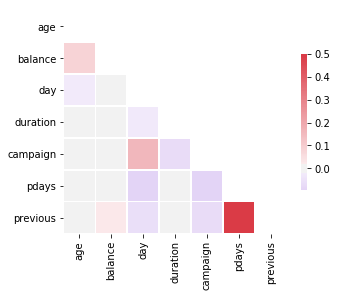

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))
    
# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Stratified Sampling
10% from 0 class
<br> 90% from 1 class

In [51]:
sample_data = bankDF.sampleBy("opened_new_td_act_no_yes", 
                              fractions={'no': 0.1, 'yes': 0.9}, seed=12345)
print('Total records are: ', sample_data.count())
sample_data.show(4)

('Total records are: ', 847)
+---+----------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|       job|marital_status|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+----------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 43|    admin.|       married|secondary|     no|  264.0|    yes|  no| cellular| 17|  apr|   113.0|     2.0| -1.0|     0.0| unknown|                      no|
| 20|   student|        single|secondary|     no|  502.0|     no|  no| cellular| 30|  apr|   261.0|     1.0| -1.0|     0.0| unknown|                     yes|
| 68|   retired|      divorced|secondary|     no| 4189.0|     no|  no|telephone| 14|  jul|   897.0|     2.0| -1.0|     0.0| unknown|                     yes|
| 32|management|       

In [52]:
sample_data.groupBy("opened_new_td_act_no_yes").count().orderBy("opened_new_td_act_no_yes").show()

+------------------------+-----+
|opened_new_td_act_no_yes|count|
+------------------------+-----+
|                      no|  375|
|                     yes|  472|
+------------------------+-----+



#### Verify for Null Values

In [53]:
bankDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
               for c in bankDF.columns]).show()

+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|job|marital_status|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|  0|  0|             0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|                       0|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Remove Null values - if any

In [54]:
data_df = bankDF.na.drop( how = 'any' )
print('Before Dropping Null Values', bankDF.count())
print('After Dropping Null Values', data_df.count())

('Before Dropping Null Values', 4521)
('After Dropping Null Values', 4521)


#### Split the data into training and test sets (30% held out for testing)

In [0]:
(trainingData, testData) = bankDF.randomSplit([0.7, 0.3])

In [56]:
trainingData.show(4)

+---+-------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|    job|marital_status|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+-------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 19|student|        single|secondary|     no|  302.0|     no|  no| cellular| 16|  jul|   205.0|     1.0| -1.0|     0.0| unknown|                     yes|
| 19|student|        single|  unknown|     no|    0.0|     no|  no| cellular| 11|  feb|   123.0|     3.0| -1.0|     0.0| unknown|                      no|
| 19|student|        single|  unknown|     no| 1169.0|     no|  no| cellular|  6|  feb|   463.0|    18.0| -1.0|     0.0| unknown|                      no|
| 20|student|        single|secondary|     no|  291.0|     no|  no|tel

In [57]:
testData.show(4)

+---+----------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|       job|marital_status|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+----------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 19|   student|        single|  primary|     no|  103.0|     no|  no| cellular| 10|  jul|   104.0|     2.0| -1.0|     0.0| unknown|                     yes|
| 21|   student|        single|  unknown|     no|  137.0|    yes|  no|  unknown| 12|  may|   198.0|     3.0| -1.0|     0.0| unknown|                      no|
| 22|   student|        single|  unknown|     no|  549.0|     no|  no| cellular|  2|  sep|   154.0|     1.0| -1.0|     0.0| unknown|                      no|
| 22|technician|        single|secondary|     no|  3

#### Define PipeLines
<br>Stages:
    -  Preprocessing
    -  Model Building & Evaluation

#### Extract Categorical and Numerical Columns from the data

In [0]:
cat_Var_Names = ['job', 'marital_status', 'education', 'default', 'housing', 
                 'day', 'contact', 'month', 'poutcome']

num_Var_Names = ['age', 'balance', 'duration', 'previous', 'pdays', 'campaign']

#### Use VectorAssembler to combine a given list of numcolumns into a single vector column.

In [0]:
from pyspark.ml.feature import VectorAssembler

vector_assembler_NumVars = VectorAssembler(inputCols=num_Var_Names, 
                                           outputCol="num_features_all")

#### Scale all the numeric attributes using MinMaxScaler
MinMaxScaler transforms a dataset of Vector rows, rescaling each feature to a specific range (often [0, 1]). 
<br>MinMaxScaler computes summary statistics on a data set and produces a MinMaxScalerModel. 
<br>The model can then transform each feature individually such that it is in the given range.

In [0]:
from pyspark.ml.feature import MinMaxScaler
min_Max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all", 
                                      outputCol = "scaled_num_features")

#### convert Categorical Variables into Numeric
Dummify (encode) the categorical variables.

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexers_Cat  = [StringIndexer(inputCol=cat_Var_Name, 
                               outputCol="{0}_index".format(cat_Var_Name))
                 for cat_Var_Name in cat_Var_Names ]
encoders_Cat  = [OneHotEncoder(inputCol=indexer.getOutputCol(), 
                               outputCol="{0}_vec".format
                               (indexer.getInputCol())) 
                 for indexer in indexers_Cat]
assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() 
                                           for encoder in encoders_Cat], 
                                outputCol="cat_features")

assembler     = VectorAssembler(inputCols=["scaled_num_features","cat_features"], 
                                outputCol="features")

#### Encode Target Attribute

In [0]:
indexer_Label = StringIndexer(inputCol="opened_new_td_act_no_yes", outputCol="label")

#### Preprocessing Steps

In [0]:
# Combine numerical attributes into a vector
# Scale above vector
# String Indexing on Categorical attributes
# OneHot Encoder on the above indexers
# Combine all the encoded Categorical vectors into a single  vector
# Combine both Numerical and Categorical into a one vector
# Target attribute
preprocessiong_Stages = [vector_assembler_NumVars] +\
                        [min_Max_Scalar_NumVars] +\
                        indexers_Cat + encoders_Cat +\
                        [assembler_Cat] +\
                        [assembler] +\
                        [indexer_Label]

In [64]:
preprocessiong_Stages

[VectorAssembler_4e25992831547bbd43af,
 MinMaxScaler_4718a0efb13e27732da6,
 StringIndexer_4d7d9d871c97c42d9fbf,
 StringIndexer_45d6a99dc9e56d190040,
 StringIndexer_43fbbc2155fd3e35fee5,
 StringIndexer_45efb258d39f51af74d7,
 StringIndexer_43c286a45603902808e9,
 StringIndexer_4581a670f28ee29ae120,
 StringIndexer_4f9d808ed5e1aec15802,
 StringIndexer_4a84b9af43bef81a8b9a,
 StringIndexer_47ddaa6c8a6a24458a43,
 OneHotEncoder_42768cc45e9ef8b59848,
 OneHotEncoder_4f9d85d29b2ae054dec0,
 OneHotEncoder_41a38d7fce934633f629,
 OneHotEncoder_4c52aa51488c21c8b8c8,
 OneHotEncoder_4192b8fe3a2d1e995491,
 OneHotEncoder_4d34ac4d831e22f57286,
 OneHotEncoder_44ce9acd9d217bd40eb0,
 OneHotEncoder_4a409b9752a5aa404570,
 OneHotEncoder_45958035c5d47886727c,
 VectorAssembler_4879822199f51df81740,
 VectorAssembler_4fac8b85d044d19d7078,
 StringIndexer_4fc28ef8b59a3a884885]

### Model Building and Evaluation

In [0]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, labelCol="label", featuresCol="features")

In [0]:
from pyspark.ml import Pipeline

lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr])

lr_Pipeline_model = lr_Pipeline.fit(trainingData)

In [67]:
len(lr_Pipeline_model.stages[-1].coefficients)

70

In [68]:
print("Coefficients: " + str(lr_Pipeline_model.stages[-1].coefficients))
print("Intercept: " + str(lr_Pipeline_model.stages[-1].intercept))

Coefficients: [-0.472625434705884,0.5543719770536176,12.840177867498678,1.4071535262547694,0.8947085141787349,-3.5193629792756935,-0.37771392398229964,-0.04283939761766435,-0.20417577454278704,0.5344416878045964,-0.007157159390884624,0.9211176397347599,-0.13347935237648662,-0.07575998078971614,-0.8842947761337331,-0.9126230601776995,0.4031683927864023,-0.31462088069582195,-0.033755829375197784,-0.06508255340737681,0.19822318777194933,-0.09771582626288679,0.5213569683419658,-0.3126327121866345,-0.833571625930229,0.6922699472818489,0.2502883950801509,-0.7759486430266302,-0.4791500641895002,-1.47452632161626,-0.33243121299839706,-0.3593211789595855,-0.8632041215216825,-0.1437725569384308,0.3835417888180103,0.02620370655523632,0.8804764185418367,0.31347060343113786,-0.8412078421912963,0.12292669605368223,0.5023746756422656,0.24107112253105586,0.5673883393078601,-0.05377726542220311,-0.13778188643778486,0.6273324274205374,-0.28912557146789414,0.2280314075304199,0.030162128930754185,0.418967

In [69]:
lr_Pipeline_model.stages[-3]

VectorAssembler_4fac8b85d044d19d7078

In [0]:
train_predictions_lr = lr_Pipeline_model.transform(trainingData)
test_predictions_lr = lr_Pipeline_model.transform(testData)

In [71]:
test_predictions_lr.show(2, truncate=False)

+---+-------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+-------------------------------+--------------------------------------------------------------------------------------------+---------+--------------------+---------------+-------------+-------------+---------+-------------+-----------+--------------+---------------+------------------+-------------+-------------+-------------+---------------+-------------+--------------+-------------+----------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+----------------------------------------+----------+
|age|job    |marital_status|education|default|balance|housing|loan|contact |day|month|duration|campaign|pdays|previous|poutcome|opened_new_

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_lr = train_predictions_lr.select("prediction", 
                                                           "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy_lr = evaluator.evaluate(predictionAndLabels_train_lr)
print("Train set accuracy  = " + str(train_accuracy_lr))
print("Train Error = %g" % (1.0 - train_accuracy_lr))

predictionAndLabels_test_lr = test_predictions_lr.select("prediction", "label")
test_accuracy_lr = evaluator.evaluate(predictionAndLabels_test_lr)
print("Test set accuracy = " + str(test_accuracy_lr))
print("Test Error = %g" % (1.0 - test_accuracy_lr))

Train set accuracy  = 0.908291457286
Train Error = 0.0917085
Test set accuracy = 0.883320867614
Test Error = 0.116679


### METRICS
Below we calculate some more metrics. The number of false and true positive and negative predictions is also useful:
- **true positives (TP):** These are cases in which we predicted yes (they had term deposit), and they do had the 
- **true negatives (TN):** We predicted no, and they don't have the term deposit.
- **false positives (FP):** We predicted yes, but they don't actually have the term deposit. (Also known as a "Type I error.")
- **false negatives (FN):** We predicted no, but they actually do have the term deposit. (Also known as a "Type II error.")

This is a list of metrics that are often computed from a confusion matrix for a binary classifier:
    
- **Accuracy:** Overall, how often is the classifier correct? (TP+TN)/total
- **Misclassification Rate:** Overall, how often is it wrong? (FP+FN)/total
    - equivalent to 1 minus Accuracy, also known as "**Error Rate**"
- **True Positive Rate:** When it's actually yes, how often does it predict yes? TP/actual yes
    - also known as "**Sensitivity**" or "**Recall**"
- **False Positive Rate:** When it's actually no, how often does it predict yes? FP/actual no
- **True Negative Rate:** When it's actually no, how often does it predict no? TN/actual no
    - equivalent to 1 minus False Positive Rate, also known as "**Specificity**"
- **Precision:** When it predicts yes, how often is it correct? TP/predicted yes
- **F1 Score:** This is a weighted average of the true positive rate (recall) and precision. 

In [73]:
true_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
print "TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lr.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 1) & (predictionAndLabels_test_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 0) & (predictionAndLabels_test_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 0) & (predictionAndLabels_test_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 1) & (predictionAndLabels_test_lr.prediction == 0.0)].count()
print "TEST METRICS - LINEAR MODEL - BINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lr.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))


TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY
True Positives: 126
True Negatives: 2766
False Positives: 58
False Negatives: 234
Total 3184
Precission:  0.684782608696
Recall:  0.35
F1 Score:  0.463235294118
*****************************************************************************
TEST METRICS - LINEAR MODEL - BINOMIAL FAMILY
True Positives: 42
True Negatives: 1139
False Positives: 37
False Negatives: 119
Total 3184
Precission:  0.53164556962
Recall:  0.260869565217
F1 Score:  0.35


#### Tuning LR Model

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, [0.5])\
    .build()
    
lr_crossval = CrossValidator(estimator=lr_Pipeline,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator,
                             numFolds=2)   

In [0]:
# Run cross-validation, and choose the best set of parameters.
lr_crossval_Model = lr_crossval.fit(trainingData)

In [0]:
train_predictions_lrcv = lr_crossval_Model.transform(trainingData)
test_predictions_lrcv = lr_crossval_Model.transform(testData)

In [77]:
predictionAndLabels_train_lrcv = train_predictions_lrcv.select("prediction", "label")
train_accuracycv = evaluator.evaluate(predictionAndLabels_train_lrcv)
print("Train set accuracy  = " + str(train_accuracycv))

predictionAndLabels_test_lrcv = test_predictions_lrcv.select("prediction", "label")
test_accuracycv = evaluator.evaluate(predictionAndLabels_test_lrcv)
print("Test set accuracy = " + str(test_accuracycv))

Train set accuracy  = 0.888190954774
Test set accuracy = 0.879581151832


#### Confusion Matrix

In [0]:
train_pred_pandas = predictionAndLabels_train_lr.toPandas()
train_actuals = train_pred_pandas.label.tolist()
train_predictions = train_pred_pandas.prediction.tolist()


test_pred_pandas = predictionAndLabels_test_lr.toPandas()
test_actuals = test_pred_pandas.label.tolist()
test_predictions = test_pred_pandas.prediction.tolist()
from sklearn import metrics as smetrics
cm = smetrics.confusion_matrix(train_actuals, train_predictions)

              Not Approved  Approved
Not Approved          2766        58
Approved               234       126


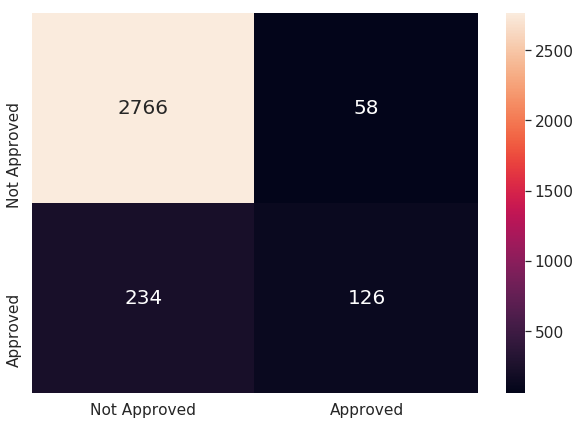

In [79]:
df_cm = pd.DataFrame(cm)
df_cm.index = ['Not Approved', 'Approved']
df_cm.columns = ['Not Approved', 'Approved']
names=['Not Approved', 'Approved']
print(df_cm)
fig = plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"size": 20})# 

#Multinomial Logistic Regression

In [0]:
from pyspark.ml.classification import LogisticRegression
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

In [0]:
from pyspark.ml import Pipeline

mlr_Pipeline = Pipeline(stages=preprocessiong_Stages+[mlr])

mlr_Pipeline_model = mlr_Pipeline.fit(trainingData)

In [0]:
train_predictions_mlr = mlr_Pipeline_model.transform(trainingData)
test_predictions_mlr = mlr_Pipeline_model.transform(testData)

In [83]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_mlr = train_predictions_mlr.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_mlr)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_mlr = test_predictions_mlr.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_mlr)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.886934673367
Train Error = 0.113065
Test set accuracy = 0.879581151832
Test Error = 0.120419


In [84]:
true_positive = predictionAndLabels_train_mlr[(predictionAndLabels_train_mlr.label == 1) & (predictionAndLabels_train_mlr.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_mlr[(predictionAndLabels_train_mlr.label == 0) & (predictionAndLabels_train_mlr.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_mlr[(predictionAndLabels_train_mlr.label == 0) & (predictionAndLabels_train_mlr.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_mlr[(predictionAndLabels_train_mlr.label == 1) & (predictionAndLabels_train_mlr.prediction == 0.0)].count()
print "TRAIN METRICS - LINEAR MODEL - MULTINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_mlr.count()
#precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_mlr[(predictionAndLabels_test_mlr.label == 1) & (predictionAndLabels_test_mlr.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_mlr[(predictionAndLabels_test_mlr.label == 0) & (predictionAndLabels_test_mlr.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_mlr[(predictionAndLabels_test_mlr.label == 0) & (predictionAndLabels_test_mlr.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_mlr[(predictionAndLabels_test_mlr.label == 1) & (predictionAndLabels_test_mlr.prediction == 0.0)].count()
print "TEST METRICS - LINEAR MODEL - MULTINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_mlr.count()
#precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - LINEAR MODEL - MULTINOMIAL FAMILY
True Positives: 0
True Negatives: 2824
False Positives: 0
False Negatives: 360
Total 3184
Precission:  0.53164556962
Recall:  0.0
F1 Score:  0.0
*****************************************************************************
TEST METRICS - LINEAR MODEL - MULTINOMIAL FAMILY
True Positives: 0
True Negatives: 1176
False Positives: 0
False Negatives: 161
Total 3184
Precission:  0.53164556962
Recall:  0.0
F1 Score:  0.0


#Decision Tree Classifier

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [0]:
dt_Pipeline = Pipeline(stages=preprocessiong_Stages+[dt]) 

dt_Pipeline_model = dt_Pipeline.fit(trainingData)

In [0]:
train_predictions_dt = dt_Pipeline_model.transform(trainingData)
test_predictions_dt = dt_Pipeline_model.transform(testData)

In [88]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_dt = train_predictions_dt.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_dt)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_dt = test_predictions_dt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_dt)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.915201005025
Train Error = 0.084799
Test set accuracy = 0.890800299177
Test Error = 0.1092


In [89]:
true_positive = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 1) & (predictionAndLabels_train_dt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 0) & (predictionAndLabels_train_dt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 0) & (predictionAndLabels_train_dt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 1) & (predictionAndLabels_train_dt.prediction == 0.0)].count()
print "TRAIN METRICS - DECISSION TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_dt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 1) & (predictionAndLabels_test_dt.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 0) & (predictionAndLabels_test_dt.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 0) & (predictionAndLabels_test_dt.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 1) & (predictionAndLabels_test_dt.prediction == 0.0)].count()
print "\n\nTEST METRICS - DECISSION TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_dt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - DECISSION TREE CLASSIFIER
True Positives: 155
True Negatives: 2759
False Positives: 65
False Negatives: 205
Total 3184
Precission:  0.704545454545
Recall:  0.430555555556
F1 Score:  0.534482758621
*****************************************************************************


TEST METRICS - DECISSION TREE CLASSIFIER
True Positives: 49
True Negatives: 1142
False Positives: 34
False Negatives: 112
Total 3184
Precission:  0.590361445783
Recall:  0.304347826087
F1 Score:  0.401639344262


In [0]:
treeModel = dt_Pipeline_model.stages[23]

In [91]:
print "Learned classification tree model:"
print treeModel.toDebugString

Learned classification tree model:
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_48ad89a52669a4374f57) of depth 5 with 61 nodes
  If (feature 2 <= 0.12727573651108903)
   If (feature 2 <= 0.06835484938761999)
    If (feature 65 in {1.0})
     If (feature 5 <= 0.030612244897959183)
      If (feature 17 in {1.0})
       Predict: 0.0
      Else (feature 17 not in {1.0})
       Predict: 1.0
     Else (feature 5 > 0.030612244897959183)
      Predict: 0.0
    Else (feature 65 not in {1.0})
     If (feature 66 in {1.0})
      If (feature 1 <= 5.94601022713759E-5)
       Predict: 1.0
      Else (feature 1 > 5.94601022713759E-5)
       Predict: 0.0
     Else (feature 66 not in {1.0})
      If (feature 16 in {1.0})
       Predict: 0.0
      Else (feature 16 not in {1.0})
       Predict: 0.0
   Else (feature 2 > 0.06835484938761999)
    If (feature 4 <= 0.06880733944954129)
     If (feature 65 in {1.0})
      If (feature 1 <= 0.0034367939112855276)
       Predict: 0.0
      Else (fe

#RandomForest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [0]:
rf_Pipeline = Pipeline(stages=preprocessiong_Stages+[rf]) 
rf_Pipeline_model = rf_Pipeline.fit(trainingData)

In [0]:
train_predictions_rf = rf_Pipeline_model.transform(trainingData)
test_predictions_rf = rf_Pipeline_model.transform(testData)

In [95]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_rf = train_predictions_rf.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_rf)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_rf = test_predictions_rf.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_rf)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.888819095477
Train Error = 0.111181
Test set accuracy = 0.879581151832
Test Error = 0.120419


In [96]:
true_positive = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 1) & (predictionAndLabels_train_rf.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 0) & (predictionAndLabels_train_rf.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 0) & (predictionAndLabels_train_rf.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 1) & (predictionAndLabels_train_rf.prediction == 0.0)].count()
print "TRAIN METRICS - RANDOM FOREST CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_rf.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")

true_positive = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 1) & (predictionAndLabels_test_rf.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 0) & (predictionAndLabels_test_rf.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 0) & (predictionAndLabels_test_rf.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 1) & (predictionAndLabels_test_rf.prediction == 0.0)].count()
print "TEST METRICS - RANDOM FOREST CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_rf.count()
#precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - RANDOM FOREST CLASSIFIER
True Positives: 6
True Negatives: 2824
False Positives: 0
False Negatives: 354
Total 3184
Precission:  1.0
Recall:  0.0166666666667
F1 Score:  0.0327868852459
*****************************************************************************
TEST METRICS - RANDOM FOREST CLASSIFIER
True Positives: 0
True Negatives: 1176
False Positives: 0
False Negatives: 161
Total 3184
Precission:  1.0
Recall:  0.0
F1 Score:  0.0


#GradientBoostingTree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [0]:
gbt_Pipeline = Pipeline(stages=preprocessiong_Stages+[gbt]) 
gbt_Pipeline_model = gbt_Pipeline.fit(trainingData)

In [0]:
train_predictions_gbt = gbt_Pipeline_model.transform(trainingData)
test_predictions_gbt = gbt_Pipeline_model.transform(testData)

In [100]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_gbt = train_predictions_gbt.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_gbt)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_gbt = test_predictions_gbt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_gbt)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.933103015075
Train Error = 0.066897
Test set accuracy = 0.889304412865
Test Error = 0.110696


In [101]:
true_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
print "TRAIN METRICS - GRADIENT-BOOSTED TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_gbt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
print "TEST METRICS - GRADIENT-BOOSTED TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_gbt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - GRADIENT-BOOSTED TREE CLASSIFIER
True Positives: 191
True Negatives: 2780
False Positives: 44
False Negatives: 169
Total 3184
Precission:  0.812765957447
Recall:  0.530555555556
F1 Score:  0.642016806723
*****************************************************************************
TEST METRICS - GRADIENT-BOOSTED TREE CLASSIFIER
True Positives: 50
True Negatives: 1139
False Positives: 37
False Negatives: 111
Total 3184
Precission:  0.574712643678
Recall:  0.310559006211
F1 Score:  0.403225806452


# Mutilayer Perceptron Classifier

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# specify layers for the neural network:
# input layer of size 71 (features), two intermediate of size 50 and 40
# and output of size 2 (classes)
layers = [70, 50, 40, 2]
# create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, 
                                     blockSize=128, seed=1234)

In [0]:
mlp_Pipeline = Pipeline(stages=preprocessiong_Stages+[mlp]) 
mlp_Pipeline_model = mlp_Pipeline.fit(trainingData)

In [0]:
train_predictions_mlp = mlp_Pipeline_model.transform(trainingData)
test_predictions_mlp = mlp_Pipeline_model.transform(testData)

In [105]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_mlp = train_predictions_mlp.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_mlp)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_mlp = test_predictions_mlp.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_mlp)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.943781407035
Train Error = 0.0562186
Test set accuracy = 0.866118175019
Test Error = 0.133882


In [106]:
true_positive = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 1) & (predictionAndLabels_train_mlp.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 0) & (predictionAndLabels_train_mlp.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 0) & (predictionAndLabels_train_mlp.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 1) & (predictionAndLabels_train_mlp.prediction == 0.0)].count()
print "TRAIN METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_mlp.count()
precission = true_positive / float(true_positive + false_positive + 1)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall+1)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 1) & (predictionAndLabels_test_mlp.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 0) & (predictionAndLabels_test_mlp.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 0) & (predictionAndLabels_test_mlp.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 1) & (predictionAndLabels_test_mlp.prediction == 0.0)].count()
print "TEST METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_mlp.count()
precission = true_positive / (float(true_positive + false_positive) + 1)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall+1)))

TRAIN METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER
True Positives: 244
True Negatives: 2761
False Positives: 63
False Negatives: 116
Total 3184
Precission:  0.792207792208
Recall:  0.677777777778
F1 Score:  0.434772448443
*****************************************************************************
TEST METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER
True Positives: 59
True Negatives: 1099
False Positives: 77
False Negatives: 102
Total 3184
Precission:  0.430656934307
Recall:  0.366459627329
F1 Score:  0.175635106839


# Linear SVM Classifier

In [0]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [0]:
lsvc_Pipeline = Pipeline(stages=preprocessiong_Stages+[lsvc]) 
lsvc_Pipeline_model = lsvc_Pipeline.fit(trainingData)

In [0]:
train_predictions_lsvc = lsvc_Pipeline_model.transform(trainingData)
test_predictions_lsvc = lsvc_Pipeline_model.transform(testData)

In [110]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_lsvc = train_predictions_lsvc.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_lsvc)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_lsvc = test_predictions_lsvc.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_lsvc)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.886934673367
Train Error = 0.113065
Test set accuracy = 0.879581151832
Test Error = 0.120419


In [111]:
true_positive = predictionAndLabels_train_lsvc[(predictionAndLabels_train_lsvc.label == 1) & (predictionAndLabels_train_lsvc.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_lsvc[(predictionAndLabels_train_lsvc.label == 0) & (predictionAndLabels_train_lsvc.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_lsvc[(predictionAndLabels_train_lsvc.label == 0) & (predictionAndLabels_train_lsvc.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_lsvc[(predictionAndLabels_train_lsvc.label == 1) & (predictionAndLabels_train_lsvc.prediction == 0.0)].count()
print "TRAIN METRICS - Linear Support Vector Machine CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lsvc.count()
precission = true_positive / float(true_positive + false_positive+1)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall+1)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_lsvc[(predictionAndLabels_test_lsvc.label == 1) & (predictionAndLabels_test_lsvc.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_lsvc[(predictionAndLabels_test_lsvc.label == 0) & (predictionAndLabels_test_lsvc.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_lsvc[(predictionAndLabels_test_lsvc.label == 0) & (predictionAndLabels_test_lsvc.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_lsvc[(predictionAndLabels_test_lsvc.label == 1) & (predictionAndLabels_test_lsvc.prediction == 0.0)].count()
print "TEST METRICS - Linear Support Vector Machine CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lsvc.count()
precission = true_positive / float(true_positive + false_positive+1)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall+1)))

TRAIN METRICS - Linear Support Vector Machine CLASSIFIER
True Positives: 0
True Negatives: 2824
False Positives: 0
False Negatives: 360
Total 3184
Precission:  0.0
Recall:  0.0
F1 Score:  0.0
*****************************************************************************
TEST METRICS - Linear Support Vector Machine CLASSIFIER
True Positives: 0
True Negatives: 1176
False Positives: 0
False Negatives: 161
Total 3184
Precission:  0.0
Recall:  0.0
F1 Score:  0.0


# NaiveBayes Classifier

In [0]:
from pyspark.ml.classification import NaiveBayes
nbc = NaiveBayes(smoothing=1.0, modelType="multinomial")

In [0]:
nbc_Pipeline = Pipeline(stages=preprocessiong_Stages+[nbc]) 
nbc_Pipeline_model = nbc_Pipeline.fit(trainingData)

In [0]:
train_predictions_nbc = nbc_Pipeline_model.transform(trainingData)
test_predictions_nbc = nbc_Pipeline_model.transform(testData)

In [115]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_nbc = train_predictions_nbc.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_nbc)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_nbc = test_predictions_nbc.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_nbc)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.881909547739
Train Error = 0.11809
Test set accuracy = 0.868362004488
Test Error = 0.131638


In [116]:
true_negative = predictionAndLabels_train_nbc[(predictionAndLabels_train_nbc.label == 0) & (predictionAndLabels_train_nbc.prediction == 0.0)].count()
true_positive = predictionAndLabels_train_nbc[(predictionAndLabels_train_nbc.label == 1) & (predictionAndLabels_train_nbc.prediction == 1.0)].count()
false_positive = predictionAndLabels_train_nbc[(predictionAndLabels_train_nbc.label == 0) & (predictionAndLabels_train_nbc.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_nbc[(predictionAndLabels_train_nbc.label == 1) & (predictionAndLabels_train_nbc.prediction == 0.0)].count()
print "TRAIN METRICS - Naive Bayes CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_nbc.count()
precision = true_positive / float(true_positive + false_positive)
print "Precision: ", precision
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_nbc[(predictionAndLabels_test_nbc.label == 1) & (predictionAndLabels_test_nbc.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_nbc[(predictionAndLabels_test_nbc.label == 0) & (predictionAndLabels_test_nbc.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_nbc[(predictionAndLabels_test_nbc.label == 0) & (predictionAndLabels_test_nbc.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_nbc[(predictionAndLabels_test_nbc.label == 1) & (predictionAndLabels_test_nbc.prediction == 0.0)].count()
print "TEST METRICS - Naive Bayes CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_nbc.count()
precision = true_positive / float(true_positive + false_positive)
print "Precision: ", precision
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - Naive Bayes CLASSIFIER
True Positives: 56
True Negatives: 2752
False Positives: 72
False Negatives: 304
Total 3184
Precision:  0.4375
Recall:  0.155555555556
F1 Score:  0.0
*****************************************************************************
TEST METRICS - Naive Bayes CLASSIFIER
True Positives: 19
True Negatives: 1142
False Positives: 34
False Negatives: 142
Total 3184
Precision:  0.358490566038
Recall:  0.11801242236
F1 Score:  0.0
